# Cryptocurrency for Energy Conscious Investors

WIP! Getting some ideas together here to narrow down the search for coin historicla trade data. :p

## Overview

We want to utilize analysis tools to evaluate viable investment strategies focussed on eco-friendly cryptocurrencies. A Monte Carlo simulator will be used to project outcome with various weight strategies.

---


## Data Retreival and Cleanup (DRAFT)

### Retreival
The coinbase api is used to pull historical data.  Their api limits to 300 records per call. So we plan a series of calls for each coin that saves the data locally as csv, then another funtion stitches them together by group.

### Cleanup
The trade history for many new crypto tickers is quite limited. So we try to grab as much history as possible then use Pandas objects to normalize the datasets.  The merged data for each crypto is stored in `/data/candles/coinbase_ETH-USD_ALL.csv`. The same pattern is used for the other datasets: `/data/trades/coinbase_ETH-USD_ALL.csv`. The filename pattern allows to uitilize the same funtionas for managing the filesystem.

* Sources
    1. **Coinbase** <- we will base first phase on this data
    2. Alpaca
* Data Structures
    1. Daily Returns (candles), Trades, Tickers, Products
    2. Metadata (products, crypto lists, etc)

---


## Quantatative Analysis ##

We've created a DataFrame for analysis by importing historic cyrypto echange data. Then, we performed our quantitative analysis which includes the following:

- **Performance** analysis to determine if any of the portfolios outperform the broader markets, lol.
- **Volatility** of each of the four fund portfolios and of the S&P 500 Index by using box plots
- **Risk** profile of each portfolio using the **standard deviation** and **beta** 
- **Risk-Return** profile using sharpe index

---


## Environment Initialization

Import all libraries used in this notebook.


In [20]:
# First import the libraries that we need to use
import os
import fnmatch
import pandas as pd
import numpy as np
import time
import requests
import json
import warnings
import hvplot.pandas
import holoviews as hv
import panel as pn
from pathlib import Path
from datetime import datetime, timedelta
from bokeh.models.formatters import DatetimeTickFormatter, NumeralTickFormatter
from utils.coinbase import *
from dotenv import load_dotenv

load_dotenv()

!nvidia-smi

Wed May 18 03:09:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.68.01    Driver Version: 512.59       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  Off |
|  0%   52C    P5    30W / 450W |   1839MiB / 24564MiB |     25%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Retrieve Metadata

Create local copies of the currencies and data products and pull into DataFrames.  These functions each return a pd.DataFrame()

In [21]:
# Get list of currencies and the exchange details from the coinbase api
currencies_df = get_currencies()
# display(currencies_df.head(3))
# display(currencies_df.tail(3))

Created CSV file: data/coinbase_currencies.csv


In [22]:
## Get full list of data products from the coinbase api
products_online_df = get_products()
# display(products_online_df.head(3))
# display(products_online_df.tail(3))

Created CSV file: data/coinbase_products.csv


## Data Selection
From the products_online_df DataFrame(), we can now choose data based on crypto or fiat or both. Filter by `base_currency` to get all crypto currencies by fiat `USD` then import into a pd.DataFrame().


In [23]:
## Filter by `base_currency` to get all crypto currencies by fiat `USD` and import into a DataFrame
usd_products_df = products_online_df.loc[(products_online_df['quote_currency'] == 'USD')].copy().drop(columns=["quote_currency"])
btc_products_df = products_online_df.loc[(products_online_df['quote_currency'] == 'BTC')].copy().drop(columns=["quote_currency"])
eth_products_df = products_online_df.loc[(products_online_df['quote_currency'] == 'ETH')].copy().drop(columns=["quote_currency"])

print(f"USD-based data has {len(usd_products_df)} records - we'll use this one for filtering when grabbing data.")
print(f"BTC-based data has {len(btc_products_df)} records")
print(f"ETH-based data has {len(eth_products_df)} records")

USD-based data has 171 records - we'll use this one for filtering when grabbing data.
BTC-based data has 66 records
ETH-based data has 6 records


### Create a list to perform our analysis

We create a python `list()` by joining our DataFrames() and filtering by the top 10 for POC.

In [24]:
# Pandas concat() inner join into a list()
"""
NOTE: For now, recreate the list from the previous output so we don't get another list, which will not match our saved data.

['SOL-ETH', 'MANA-ETH', 'LINK-ETH', 'SUSHI-ETH', 'ADA-ETH', 'BAT-ETH', 'NMR-BTC', 'CGLD-BTC', 'NU-BTC', 'BTRST-BTC']

"""

eco_coins = ['SOL-ETH', 'MANA-ETH', 'LINK-ETH', 'SUSHI-ETH', 'ADA-ETH', 'BAT-ETH', 'NMR-BTC', 'CGLD-BTC', 'NU-BTC', 'BTRST-BTC']  

# eco_coins = pd.concat([eth_products_df['id'],btc_products_df['id']], join="inner").tolist()
# eco_coins = eco_coins[0:10]

print(eco_coins)

['SOL-ETH', 'MANA-ETH', 'LINK-ETH', 'SUSHI-ETH', 'ADA-ETH', 'BAT-ETH', 'NMR-BTC', 'CGLD-BTC', 'NU-BTC', 'BTRST-BTC']


### Fetch data in 30-day increments

Historical data will be fetched in segments. Since daily return data is limited to 300 records per call, we have to collect the daily returns in a sequence then stich together.

    note: For the sake of newer cryptos, we limit the pull to 600 records so we're not blindly pulling empty data.

In [25]:
# ## Specify the Date for all data call to start/end on. The sequence is 
# ## (+/-300 days) [0,300,600,900,1200,etc...]

# seq = list(range(0, 600, 300))
# for crypt in eco_coins:
#     fetch_return_history(crypt,"2022-05-16",seq)

In [26]:
# for crypt in eco_coins:
#     merge_candle_data(crypt)

In [27]:
# # NEW - Attempting to create <named>_df.DataFrame() in the for loop.  SOmeone mentioned using a dictionarty, but no luck.

# import glob
# cwd = os.getcwd()
# # path = 'data/product/candles/merged/'
# extension = 'csv'
# # os.chdir(path)
# files = glob.glob('data/product/candles/merged/*.{}'.format(extension))
# # print(files)
# file_dict = {}
# for file in files:
#     key = file
#     df = pd.read_csv(file)
#     file_dict[key] = df
#     print(file_dict[key].head(3))
    

# # Maybe this could help automate the stitching part, idk.

In [28]:
# Just checking...
print(eco_coins)

['SOL-ETH', 'MANA-ETH', 'LINK-ETH', 'SUSHI-ETH', 'ADA-ETH', 'BAT-ETH', 'NMR-BTC', 'CGLD-BTC', 'NU-BTC', 'BTRST-BTC']


In [29]:
# (*SAD PANDA NOISES)  We have to, for now, manually pull 10 coins into DataFrames()
# Perhaps we need more cleanup within the functions to save the CSVs without the stuff we're gonna drop anyways.

link_df = pd.read_csv(Path(f"data/product/candles/merged/coinbase_LINK-ETH_candles_ALL.csv"), infer_datetime_format=True, parse_dates=True)
link_df['time'] = pd.to_datetime(link_df['time']).dt.date
link_df = link_df.set_index('date')
link_df = link_df.drop(labels=['Unnamed: 0','unix'], axis=1)

mana_df = pd.read_csv(Path(f"data/product/candles/merged/coinbase_MANA-ETH_candles_ALL.csv"), infer_datetime_format=True, parse_dates=True)
mana_df['time'] = pd.to_datetime(mana_df['time']).dt.date
mana_df = mana_df.set_index('date')
mana_df = mana_df.drop(labels=['Unnamed: 0','unix'], axis=1)

bat_df = pd.read_csv(Path(f"data/product/candles/merged/coinbase_BAT-ETH_candles_ALL.csv"), infer_datetime_format=True, parse_dates=True)
bat_df['time'] = pd.to_datetime(bat_df['time']).dt.date
bat_df = bat_df.set_index('date')
bat_df = bat_df.drop(labels=['Unnamed: 0','unix'], axis=1)

ada_df = pd.read_csv(Path(f"data/product/candles/merged/coinbase_ADA-ETH_candles_ALL.csv"), infer_datetime_format=True, parse_dates=True)
ada_df['time'] = pd.to_datetime(ada_df['time']).dt.date
ada_df = ada_df.set_index('date')
ada_df = ada_df.drop(labels=['Unnamed: 0','unix'], axis=1)

sol_df = pd.read_csv(Path(f"data/product/candles/merged/coinbase_SOL-ETH_candles_ALL.csv"), infer_datetime_format=True, parse_dates=True)
sol_df['time'] = pd.to_datetime(sol_df['time']).dt.date
sol_df = sol_df.set_index('date')
sol_df = sol_df.drop(labels=['Unnamed: 0','unix'], axis=1)

sushi_df = pd.read_csv(Path(f"data/product/candles/merged/coinbase_SUSHI-ETH_candles_ALL.csv"), infer_datetime_format=True, parse_dates=True)
sushi_df['time'] = pd.to_datetime(sushi_df['time']).dt.date
sushi_df = sushi_df.set_index('date')
sushi_df = sushi_df.drop(labels=['Unnamed: 0','unix'], axis=1)

cgld_df = pd.read_csv(Path(f"data/product/candles/merged/coinbase_CGLD-BTC_candles_ALL.csv"), infer_datetime_format=True, parse_dates=True)
cgld_df['time'] = pd.to_datetime(cgld_df['time']).dt.date
cgld_df = cgld_df.set_index('date')
cgld_df = cgld_df.drop(labels=['Unnamed: 0','unix'], axis=1)

nmr_df = pd.read_csv(Path(f"data/product/candles/merged/coinbase_NMR-BTC_candles_ALL.csv"), infer_datetime_format=True, parse_dates=True)
nmr_df['time'] = pd.to_datetime(nmr_df['time']).dt.date
nmr_df = nmr_df.set_index('date')
nmr_df = nmr_df.drop(labels=['Unnamed: 0','unix'], axis=1)

nu_df = pd.read_csv(Path(f"data/product/candles/merged/coinbase_NU-BTC_candles_ALL.csv"), infer_datetime_format=True, parse_dates=True)
nu_df['time'] = pd.to_datetime(nu_df['time']).dt.date
nu_df = nu_df.set_index('date')
nu_df = nu_df.drop(labels=['Unnamed: 0','unix'], axis=1)

btrst_df = pd.read_csv(Path(f"data/product/candles/merged/coinbase_BTRST-BTC_candles_ALL.csv"), infer_datetime_format=True, parse_dates=True)
btrst_df['time'] = pd.to_datetime(btrst_df['time']).dt.date
btrst_df = btrst_df.set_index('date')
btrst_df = btrst_df.drop(labels=['Unnamed: 0','unix'], axis=1)

# xlm_df = pd.read_csv(Path(f"data/product/candles/merged/coinbase_XLM-BTC_candles_ALL.csv"), infer_datetime_format=True, parse_dates=True)
# xlm_df['time'] = pd.to_datetime(xlm_df['time']).dt.date
# xlm_df = xlm_df.set_index('date')
# xlm_df = xlm_df.drop(labels=['Unnamed: 0','unix'], axis=1)

# eth_df = pd.read_csv(Path(f"data/product/candles/merged/coinbase_ETH-BTC_candles_ALL.csv"), infer_datetime_format=True, parse_dates=True)
# eth_df['time'] = pd.to_datetime(eth_df['time']).dt.date
# eth_df = eth_df.set_index('date')
# eth_df = eth_df.drop(labels=['Unnamed: 0','unix'], axis=1)

# zrx_df = pd.read_csv(Path(f"data/product/candles/merged/coinbase_ZRX-BTC_candles_ALL.csv"), infer_datetime_format=True, parse_dates=True)
# zrx_df['time'] = pd.to_datetime(zrx_df['time']).dt.date
# zrx_df = zrx_df.set_index('date')
# zrx_df = zrx_df.drop(labels=['Unnamed: 0','unix'], axis=1)

# zec_df = pd.read_csv(Path(f"data/product/candles/merged/coinbase_ZEC-BTC_candles_ALL.csv"), infer_datetime_format=True, parse_dates=True)
# zec_df['time'] = pd.to_datetime(zec_df['time']).dt.date
# zec_df = zec_df.set_index('date')
# zec_df = zec_df.drop(labels=['Unnamed: 0','unix'], axis=1)

print('no news is good news')

no news is good news


In [30]:
# print(f"LINK: {len(link_df)}")
# print(f"MANA: {len(mana_df)}")
# print(f"BAT: {len(bat_df)}")
# print(f"ADA: {len(ada_df)}")
# print(f"SOL: {len(sol_df)}") # <==  poor sol :(
# print(f"SUSHI: {len(sushi_df)}")
# print(f"CGLD: {len(cgld_df)}")
# print(f"NMR: {len(nmr_df)}")
# print(f"NU: {len(nu_df)}")
# print(f"BTRST: {len(btrst_df)}")

## Analysis

We will call some functions to generate stats for our crypto-currencies


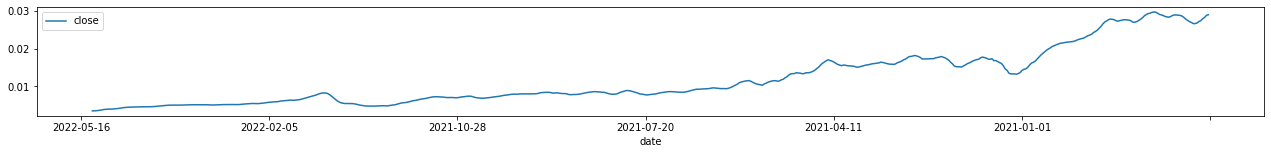

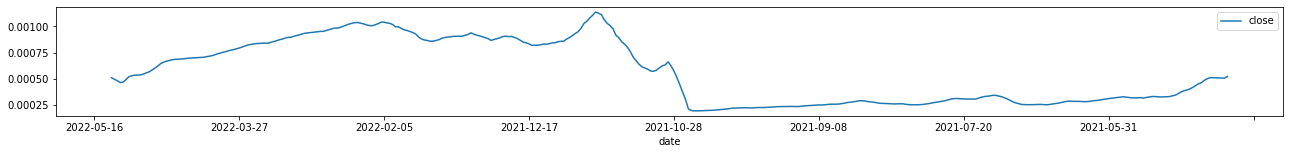

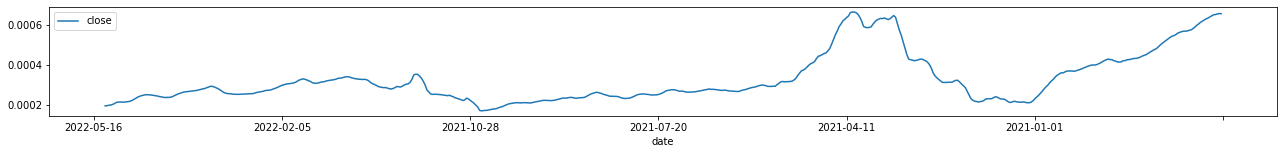

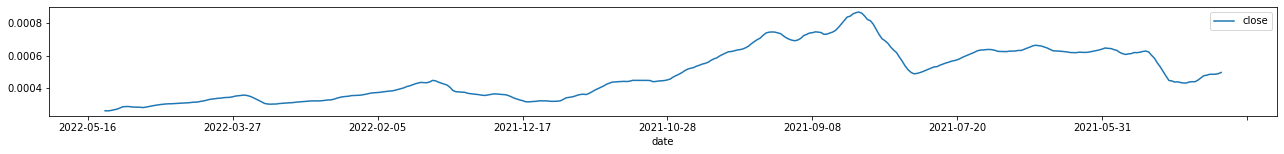

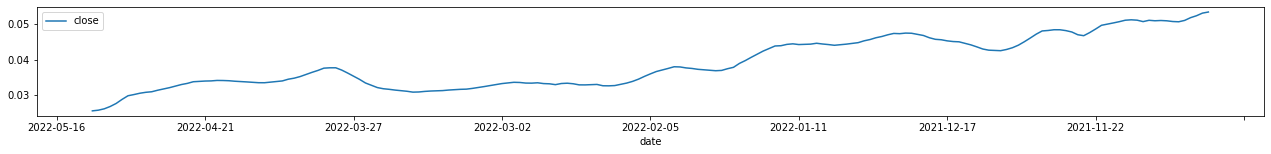

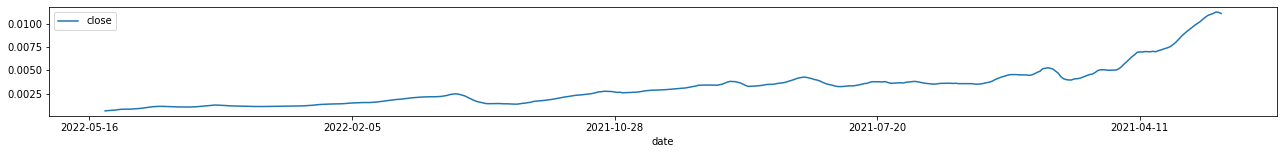

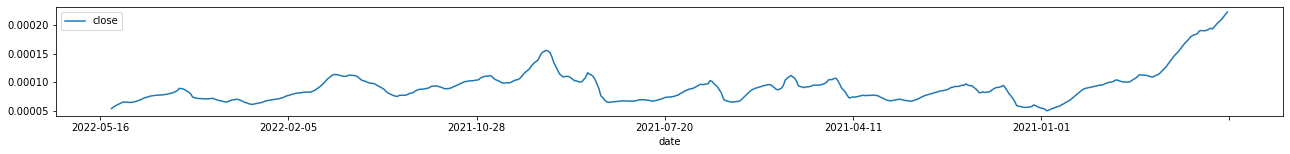

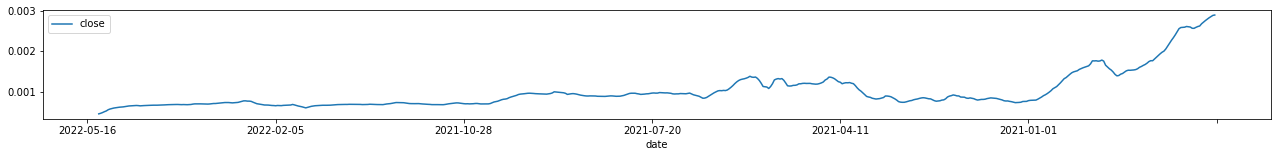

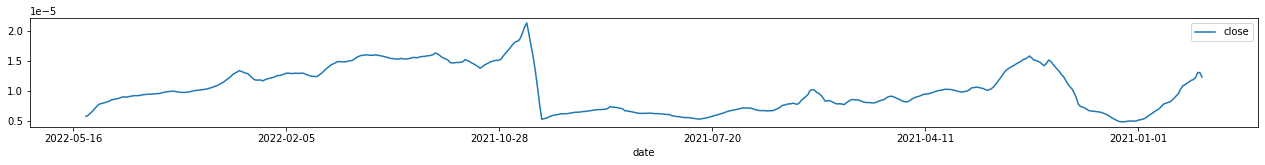

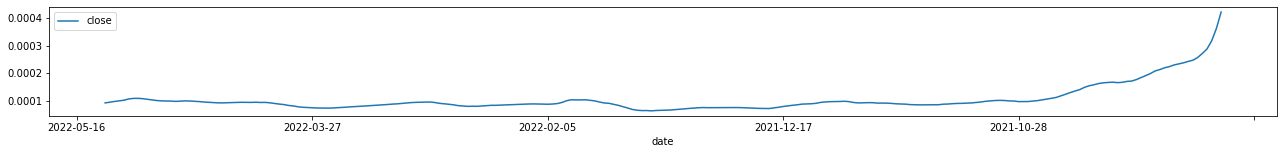

In [31]:
# Rolling 7-Day closing prices

link_7_day_rolling_df = link_df.drop(columns=["high","low","time","open","vol_fiat","volume"], inplace=False)
mana_7_day_rolling_df = mana_df.drop(columns=["high","low","time","open","vol_fiat","volume"], inplace=False)
bat_7_day_rolling_df = bat_df.drop(columns=["high","low","time","open","vol_fiat","volume"], inplace=False)
ada_7_day_rolling_df = ada_df.drop(columns=["high","low","time","open","vol_fiat","volume"], inplace=False)
sol_7_day_rolling_df = sol_df.drop(columns=["high","low","time","open","vol_fiat","volume"], inplace=False)
sushi_7_day_rolling_df = sushi_df.drop(columns=["high","low","time","open","vol_fiat","volume"], inplace=False)
cgld_7_day_rolling_df = cgld_df.drop(columns=["high","low","time","open","vol_fiat","volume"], inplace=False)
nmr_7_day_rolling_df = nmr_df.drop(columns=["high","low","time","open","vol_fiat","volume"], inplace=False)
nu_7_day_rolling_df = nu_df.drop(columns=["high","low","time","open","vol_fiat","volume"], inplace=False)
btrst_7_day_rolling_df = btrst_df.drop(columns=["high","low","time","open","vol_fiat","volume"], inplace=False)


link_7_day_rolling_plot = link_7_day_rolling_df.rolling(window=7).mean().plot(figsize=(22,2))
mana_7_day_rolling_plot = mana_7_day_rolling_df.rolling(window=7).mean().plot(figsize=(22,2))
bat_7_day_rolling_plot = bat_7_day_rolling_df.rolling(window=7).mean().plot(figsize=(22,2))
ada_7_day_rolling_plot = ada_7_day_rolling_df.rolling(window=7).mean().plot(figsize=(22,2))
sol_7_day_rolling_plot = sol_7_day_rolling_df.rolling(window=7).mean().plot(figsize=(22,2))
sushi_7_day_rolling_plot = sushi_7_day_rolling_df.rolling(window=7).mean().plot(figsize=(22,2))
cgld_7_day_rolling_plot = cgld_7_day_rolling_df.rolling(window=7).mean().plot(figsize=(22,2))
nmr_7_day_rolling_plot = nmr_7_day_rolling_df.rolling(window=7).mean().plot(figsize=(22,2))
nu_7_day_rolling_plot = nu_7_day_rolling_df.rolling(window=7).mean().plot(figsize=(22,2))
btrst_7_day_rolling_plot = btrst_7_day_rolling_df.rolling(window=7).mean().plot(figsize=(22,2))


In [32]:
## Create candle plot with overlay and sychronized sencondary plot
# Formatters for the x axis
formatter_dt = DatetimeTickFormatter(days='%m/%d\n(%Y)', months='%m/%Y', years='%Y')
formatter_usd = NumeralTickFormatter(format="$0,0")
formatter_usd_sm = NumeralTickFormatter(format="$0.0")


# ['SOL-ETH', 'MANA-ETH', 'LINK-ETH', 'SUSHI-ETH', 'ADA-ETH', 'BAT-ETH', 'NMR-BTC', 'CGLD-BTC', 'NU-BTC', 'BTRST-BTC']

def _transform_data(raw_data: pd.DataFrame):
    data = raw_data.copy(deep=True)
    data['time'] = pd.to_datetime(data['time'])
    # data = data.drop(columns=['date'])
    t_delta = timedelta(hours=0.6)
    data['time_start'] = data['time'] - 6*t_delta # rectangles start
    data['time_end'] = data['time'] + 6*t_delta    # rectangles end
    data['positive'] = ((data['close'] - data['open'])>0).astype(int)
    return data

def make_candle_stick_a(data):
    _delta = np.median(np.diff(data.time))
    candlestick_a = hv.Segments(data, kdims=['time', 'low', 'time', 'high']) * hv.Rectangles(data, kdims=['time_start','open', 'time_end', 'close'], vdims=['positive'])
    candlestick_a = candlestick_a.redim.label(Low='Values')
    return candlestick_a.opts(hv.opts.Rectangles(color='positive', cmap=['red', 'green'], alpha=0.9), hv.opts.Segments(color='gray',  alpha=0.9, line_width=0.8))

def make_daily_open_plot_a(data):
    plot = data.hvplot(x="time", y="open", kind="line", responsive=True, height=600).opts(
        xformatter=formatter_dt,
        yformatter=formatter_usd_sm,
        line_color='lightgreen',
        alpha=0.7,
        line_width=0.75,
        ylabel='',
        xlabel=''
    )
    return plot

def make_daily_close_plot_a(data):
    plot = data.hvplot(x="time", y="close", kind="line", responsive=True, height=600).opts(
        xformatter=formatter_dt,
        yformatter=formatter_usd_sm,
        line_color='lightgreen',
        alpha=0.7,
        line_width=0.75,
        ylabel='',
        xlabel=''
    )
    return plot

def make_volume_plot_a(data):
    plot = data.hvplot(x="time", y="volume", kind="area", responsive=True, height=300).opts(
        xformatter=formatter_dt,
        yformatter=formatter_usd,
        fill_color='lightgray',
        alpha=0.5,
        line_width=0.75,
        ylabel='',
        xlabel=''
    )
    return plot

def make_candle_stick_b(data2):
    _delta = np.median(np.diff(data2.time))
    candlestick_b = hv.Segments(data2, kdims=['time', 'low', 'time', 'high']) * hv.Rectangles(data2, kdims=['time_start','open', 'time_end', 'close'], vdims=['positive'])
    candlestick_b = candlestick_b.redim.label(Low='Values')
    return candlestick_b.opts(hv.opts.Rectangles(color='positive', cmap=['red', 'green'], alpha=0.9), hv.opts.Segments(color='gray',  alpha=0.9, line_width=0.8))

def make_daily_open_plot_b(data2):
    plot = data2.hvplot(x="time", y="open", kind="line", responsive=True, height=600).opts(
        xformatter=formatter_dt,
        yformatter=formatter_usd_sm,
        line_color='lightblue',
        alpha=0.7,
        line_width=0.75,
        ylabel='',
        xlabel=''
    )
    return plot

def make_daily_close_plot_b(data2):
    plot = data2.hvplot(x="time", y="close", kind="line", responsive=True, height=600).opts(
        xformatter=formatter_dt,
        yformatter=formatter_usd_sm,
        line_color='lightblue',
        alpha=0.7,
        line_width=0.75,
        ylabel='',
        xlabel=''
    )
    return plot

def make_volume_plot_b(data2):
    plot = data2.hvplot(x="time", y="volume", kind="area", responsive=True, height=300).opts(
        xformatter=formatter_dt,
        yformatter=formatter_usd,
        fill_color='lightblue',
        alpha=0.5,
        line_width=0.75,
        ylabel='',
        xlabel=''
    )
    return plot


data = _transform_data(raw_data=link_df[0:400])
data2 = _transform_data(raw_data=sushi_df[0:400])

candle_stick_plot_a = make_candle_stick_a(data)
daily_open_plot_a = make_daily_open_plot_a(data)
daily_close_plot_a = make_daily_close_plot_a(data)
volume_plot_a = make_volume_plot_a(data)

candle_stick_plot_b = make_candle_stick_b(data2)
daily_open_plot_b = make_daily_open_plot_b(data2)
daily_close_plot_b = make_daily_close_plot_b(data2)
volume_plot_b = make_volume_plot_b(data2)


pn.pane.HoloViews((((candle_stick_plot_a*daily_open_plot_a*daily_close_plot_a)*(candle_stick_plot_b*daily_open_plot_b*daily_close_plot_b))+(volume_plot_a*volume_plot_b)).cols(1), sizing_mode="stretch_both").servable()


HoloViews(Layout, sizing_mode='stretch_both')

In [33]:
## Create candle plot with overlay and sychronized sencondary plot
# Formatters for the x axis
formatter_dt = DatetimeTickFormatter(days='%m/%d\n(%Y)', months='%m/%Y', years='%Y')
formatter_usd = NumeralTickFormatter(format="$0,0")
formatter_usd_sm = NumeralTickFormatter(format="$0.0")

def _transform_data(raw_data: pd.DataFrame):
    data = raw_data.copy(deep=True)
    data['time'] = pd.to_datetime(data['time'])
    # data = data.drop(columns=['date'])
    t_delta = timedelta(hours=0.6)
    data['time_start'] = data['time'] - 6*t_delta # rectangles start
    data['time_end'] = data['time'] + 6*t_delta    # rectangles end
    data['positive'] = ((data['close'] - data['open'])>0).astype(int)
    return data

def make_candle_stick_a(data):
    _delta = np.median(np.diff(data.time))
    candlestick_a = hv.Segments(data, kdims=['time', 'low', 'time', 'high']) * hv.Rectangles(data, kdims=['time_start','open', 'time_end', 'close'], vdims=['positive'])
    candlestick_a = candlestick_a.redim.label(Low='Values')
    return candlestick_a.opts(hv.opts.Rectangles(color='positive', cmap=['red', 'green'], alpha=0.9), hv.opts.Segments(color='gray',  alpha=0.9, line_width=0.8))

def make_daily_open_plot_a(data):
    plot = data.hvplot(x="time", y="open", kind="line", responsive=True, height=600).opts(xformatter=formatter_dt, yformatter=formatter_usd_sm, line_color='orange', alpha=0.7, line_width=0.75, ylabel='', xlabel='')
    return plot

def make_daily_close_plot_a(data):
    plot = data.hvplot(x="time", y="close", kind="line", responsive=True, height=600).opts(xformatter=formatter_dt, yformatter=formatter_usd_sm, line_color='orange',alpha=0.7, line_width=0.75, ylabel='', xlabel='' )
    return plot

def make_volume_plot_a(data):
    plot = data.hvplot(x="time", y="volume", kind="area", responsive=True, height=300).opts(xformatter=formatter_dt, yformatter=formatter_usd, fill_color='pink', alpha=0.5, line_width=0.75, ylabel='', xlabel='' )
    return plot

def make_candle_stick_b(data2):
    _delta = np.median(np.diff(data2.time))
    candlestick_b = hv.Segments(data2, kdims=['time', 'low', 'time', 'high']) * hv.Rectangles(data2, kdims=['time_start','open', 'time_end', 'close'], vdims=['positive'])
    candlestick_b = candlestick_b.redim.label(Low='Values')
    return candlestick_b.opts(hv.opts.Rectangles(color='positive', cmap=['red', 'green'], alpha=0.9), hv.opts.Segments(color='gray',  alpha=0.9, line_width=0.8))

def make_daily_open_plot_b(data2):
    plot = data2.hvplot(x="time", y="open", kind="line", responsive=True, height=600).opts(xformatter=formatter_dt, yformatter=formatter_usd_sm, line_color='lightblue', alpha=0.7, line_width=0.75, ylabel='', xlabel='' )
    return plot

def make_daily_close_plot_b(data2):
    plot = data2.hvplot(x="time", y="close", kind="line", responsive=True, height=600).opts( xformatter=formatter_dt, yformatter=formatter_usd_sm, line_color='lightblue', alpha=0.7, line_width=0.75, ylabel='', xlabel='' )
    return plot

def make_volume_plot_b(data2):
    plot = data2.hvplot(x="time", y="volume", kind="area", responsive=True, height=300).opts(xformatter=formatter_dt, yformatter=formatter_usd, fill_color='lightblue', alpha=0.5, line_width=0.75, ylabel='', xlabel='' )
    return plot


data = _transform_data(raw_data=nu_df[0:300])
data2 = _transform_data(raw_data=cgld_df[0:300])

candle_stick_plot_a = make_candle_stick_a(data)
daily_open_plot_a = make_daily_open_plot_a(data)
daily_close_plot_a = make_daily_close_plot_a(data)
volume_plot_a = make_volume_plot_a(data)

candle_stick_plot_b = make_candle_stick_b(data2)
daily_open_plot_b = make_daily_open_plot_b(data2)
daily_close_plot_b = make_daily_close_plot_b(data2)
volume_plot_b = make_volume_plot_b(data2)

pn.pane.HoloViews((((candle_stick_plot_a*daily_open_plot_a*daily_close_plot_a)*(candle_stick_plot_b*daily_open_plot_b*daily_close_plot_b))+(volume_plot_a*volume_plot_b)).cols(1), sizing_mode="stretch_both").servable()

HoloViews(Layout, sizing_mode='stretch_both')

## Conclusion ##

Based on our analysis, we've choosen a few Eco-Crypto Currency Portfolios that we are likely to recommend as investment options:

**SELL!**


---
